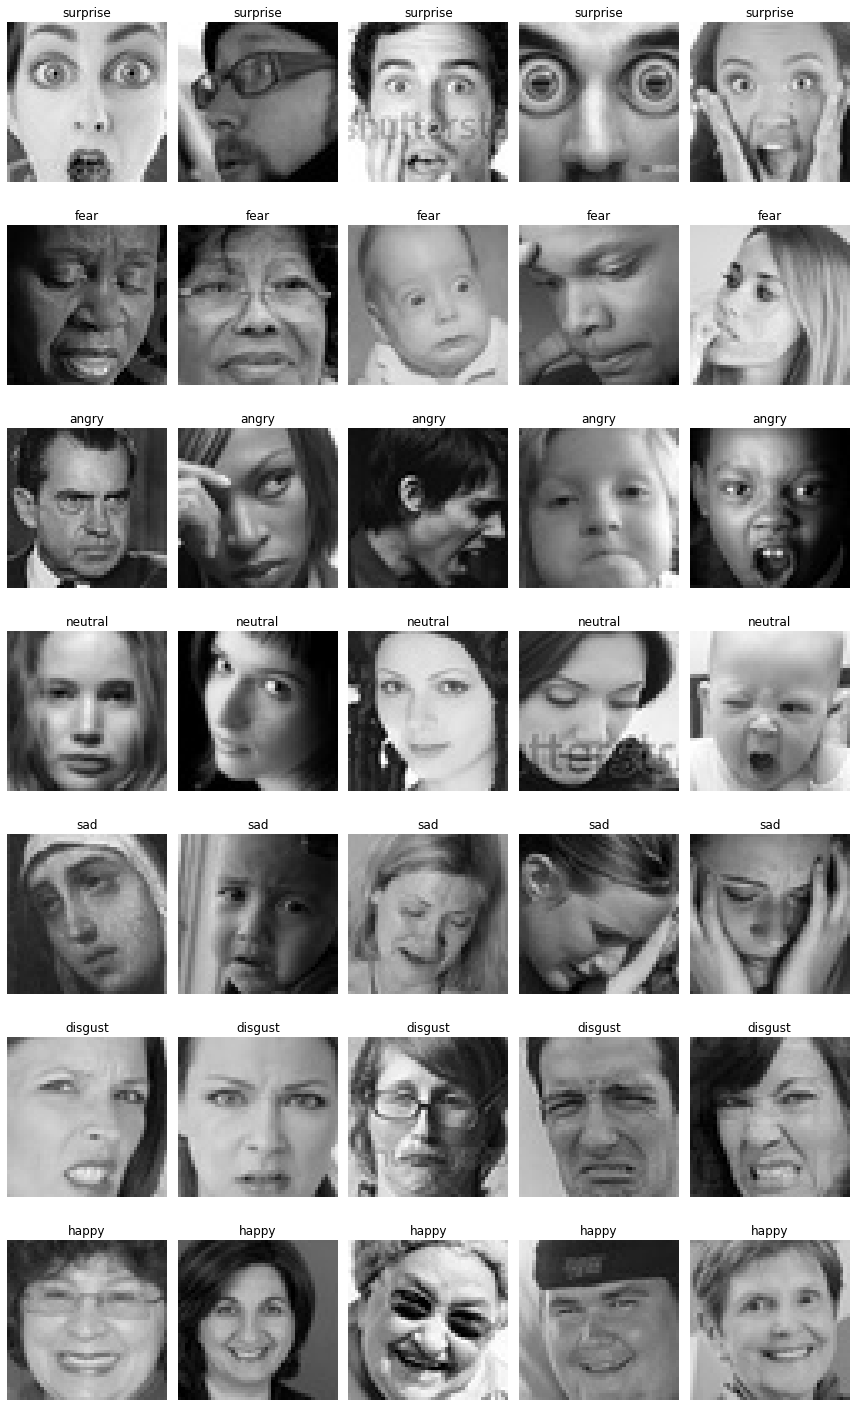

In [1]:
# display some images for every different expression

import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "../input/fer2013/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        plt.axis('off')
        plt.title(expression)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [2]:
# count number of train images for each expression
expression_count = {}
train_data_size = 0
for expression in os.listdir(base_path + "train"):
    expression_len = len(os.listdir(base_path + "train/" + expression))
    expression_count[expression] = expression_len
    train_data_size += expression_len
    print(str(expression_len) + " " + expression + " images")

3171 surprise images
4097 fear images
3995 angry images
4965 neutral images
4830 sad images
436 disgust images
7215 happy images


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 64

datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "test",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).

In [4]:
class_weights = {}
for k in expression_count:
    class_weights[train_generator.class_indices[k]] = (1.0*train_data_size)/(expression_count[k]*7.0)

class_weights

{6: 1.293372978330405,
 2: 1.0010460615781582,
 0: 1.0266046844269623,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 1: 9.406618610747051,
 3: 0.5684387684387684}

As from the above data we can see that our data non-uniform train data. Therefore we are assigning class weights for the better performance of our algorithm

Convulution Neural Networks(CNN) are best suitable for image processing as they extract all the necessary features from our image. Convolutional Neural Networks have Convolutional layers that apply sliding functions to group of pixels that are next to each other. Therefore those structures have a better understanding of patterns that we can observe in images.


In [5]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5


We define our CNN with the following global architecture:

* 4 convolutional layers
* 2 fully connected layers


The convolutional layers will extract relevant features from the images and the fully connected layers will focus on using these features to classify well our images.
Fully connected layers will be then used to classify our images into respective classes. 

In [6]:
epochs = 100

from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)

callbacks_list = [checkpoint, early_stop]

history = model.fit(train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    epochs = epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    callbacks = callbacks_list,
                    class_weight = class_weights)

Epoch 1/100
448/448 [==============================] - 181s 396ms/step - loss: 2.2703 - accuracy: 0.1698 - val_loss: 2.0470 - val_accuracy: 0.1318
Epoch 2/100
448/448 [==============================] - 48s 107ms/step - loss: 2.0587 - accuracy: 0.1992 - val_loss: 1.8415 - val_accuracy: 0.2367
Epoch 3/100
448/448 [==============================] - 48s 108ms/step - loss: 1.9834 - accuracy: 0.2235 - val_loss: 1.8767 - val_accuracy: 0.2354
Epoch 4/100
448/448 [==============================] - 48s 108ms/step - loss: 1.8583 - accuracy: 0.2570 - val_loss: 1.8243 - val_accuracy: 0.2487
Epoch 5/100
448/448 [==============================] - 47s 106ms/step - loss: 1.8260 - accuracy: 0.2760 - val_loss: 1.7802 - val_accuracy: 0.3039
Epoch 6/100
448/448 [==============================] - 47s 106ms/step - loss: 1.7614 - accuracy: 0.3061 - val_loss: 1.7505 - val_accuracy: 0.3299
Epoch 7/100
448/448 [==============================] - 46s 103ms/step - loss: 1.7228 - accuracy: 0.3191 - val_loss: 1.7922 

# Analyze the results

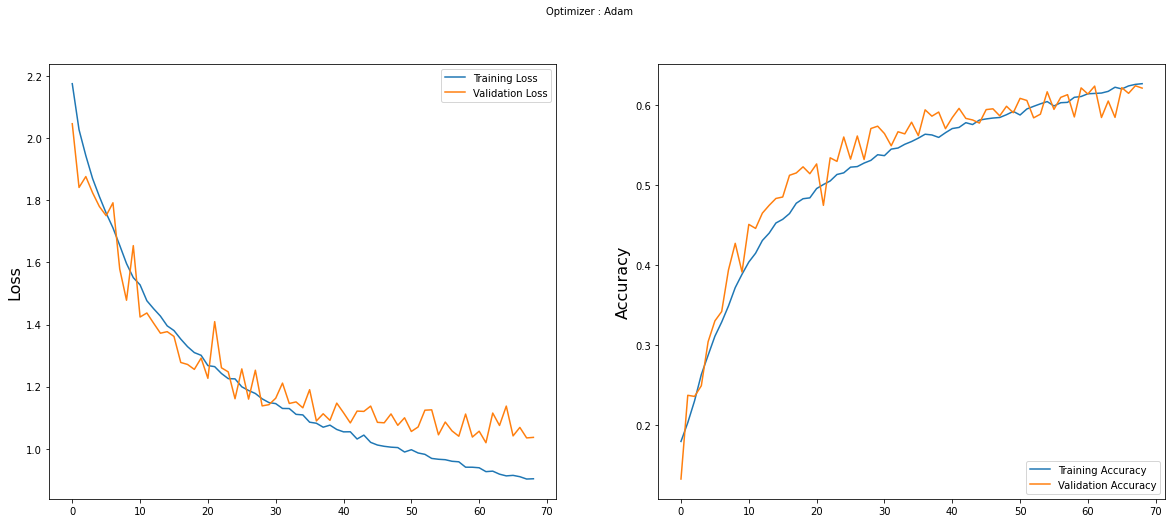

In [7]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(122)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Classification Report
              precision    recall  f1-score   support

       angry       0.56      0.54      0.55       958
     disgust       0.41      0.78      0.54       111
        fear       0.54      0.31      0.40      1024
       happy       0.88      0.80      0.84      1774
     neutral       0.50      0.72      0.59      1233
         sad       0.52      0.46      0.49      1247
    surprise       0.72      0.81      0.76       831

    accuracy                           0.62      7178
   macro avg       0.59      0.63      0.59      7178
weighted avg       0.63      0.62      0.62      7178



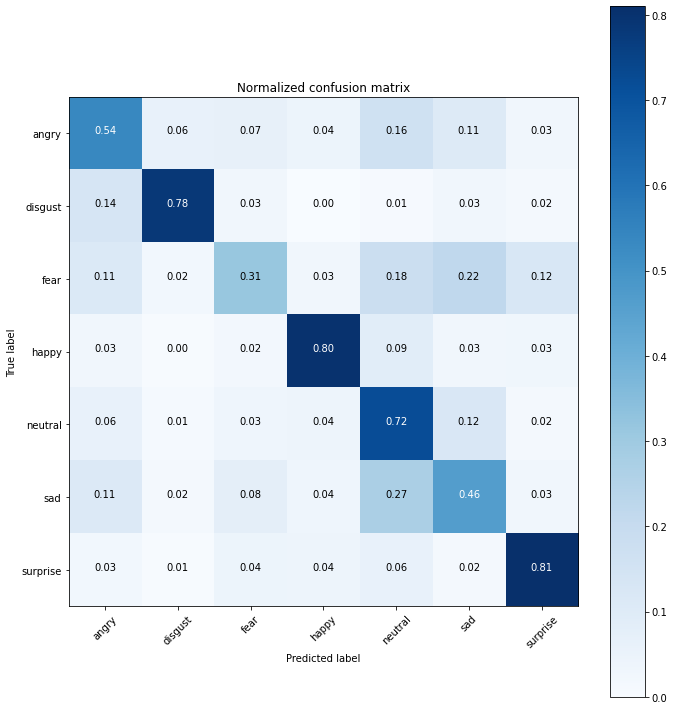

In [8]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# classification report
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=class_names))

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')